In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# We will use mlflow to track our experiments
import mlflow

In [2]:
air_quality = pd.read_csv('../data/processed/air-quality_interpolated.csv')
air_quality

,station,date,SO_2,CO,NO,NO_2,PM25,PM10,NOx,O_3,...,average_temperature,rainfall,minimum_temperature,maximum_temperature,wind_direction,average_wind_speed,maximum_wind_speed,maximum_ultraviolet_index,maximum_pressure,minimum_pressure
0,28079004,2001-01-01,17.0,0.8,45.0,58.0,NaN,NaN,127.0,NaN,...,8.3,4.6,5.7,10.8,23.7,1.4,12.1,0.0,937.9,930.1
1,28079008,2001-01-01,11.0,1.0,59.0,53.0,NaN,20.0,143.0,21.0,...,8.2,5.2,5.6,10.7,23.0,2.2,11.7,0.0,937.9,930.1
2,28079011,2001-01-01,NaN,NaN,46.0,45.0,NaN,NaN,115.0,NaN,...,8.2,4.9,5.7,10.7,23.3,1.9,11.9,0.0,937.9,930.1
3,28079016,2001-01-01,NaN,0.6,23.0,47.0,NaN,NaN,82.0,23.0,...,8.2,5.1,5.5,10.7,23.2,2.2,11.9,0.0,938.4,930.5
4,28079017,2001-01-01,12.0,NaN,61.0,46.0,NaN,NaN,140.0,23.0,...,8.7,6.6,6.4,11.1,26.5,4.7,15.5,0.0,942.4,934.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135136,28079056,2020-12-31,NaN,0.3,35.0,40.0,7.0,10.0,94.0,38.0,...,2.9,0.9,-1.5,7.4,24.5,4.4,12.6,6.4,940.2,930.0
135137,28079057,2020-12-31,2.0,0.4,21.0,40.0,NaN,12.0,72.0,NaN,...,3.0,1.3,-2.3,8.3,21.5,4.2,13.1,4.2,942.2,931.9
135138,28079058,2020-12-31,NaN,NaN,4.0,11.0,NaN,NaN,16.0,39.0,...,3.1,1.5,-2.4,8.8,24.4,4.2,12.4,5.7,934.3,924.9
135139,28079059,2020-12-31,NaN,NaN,4.0,20.0,NaN,NaN,25.0,25.0,...,2.4,1.1,-3.5,8.2,21.0,4.2,13.3,4.0,947.9,938.3


Vamos a hacer pruebas con pocos datos para ver cómo procesar los datos para el modelo LSTM.

In [3]:
# filter air quality data to only include 2018 data for 1 station
# air_quality = air_quality[air_quality['date'] >= '2015-01-01']
# air_quality = air_quality[air_quality['date'] <= '2018-12-31']
air_quality = air_quality[air_quality['station'] == 28079008]
air_quality

,station,date,SO_2,CO,NO,NO_2,PM25,PM10,NOx,O_3,...,average_temperature,rainfall,minimum_temperature,maximum_temperature,wind_direction,average_wind_speed,maximum_wind_speed,maximum_ultraviolet_index,maximum_pressure,minimum_pressure
1,28079008,2001-01-01,11.0,1.0,59.0,53.0,NaN,20.0,143.0,21.0,...,8.2,5.2,5.6,10.7,23.0,2.2,11.7,0.0,937.9,930.1
13,28079008,2001-01-02,10.0,1.0,75.0,65.0,NaN,28.0,179.0,25.0,...,8.8,0.1,6.3,11.2,28.0,4.4,12.8,4.3,939.7,931.0
25,28079008,2001-01-03,11.0,1.0,86.0,69.0,NaN,34.0,201.0,17.0,...,7.5,2.8,5.6,9.4,22.0,3.9,10.0,0.5,942.2,936.9
37,28079008,2001-01-04,12.0,0.9,99.0,71.0,NaN,37.0,223.0,18.0,...,9.2,0.7,7.1,11.2,23.0,3.1,11.4,1.4,941.9,935.8
49,28079008,2001-01-05,10.0,1.2,112.0,63.0,NaN,31.0,235.0,11.0,...,10.0,12.2,6.5,13.6,20.0,2.5,12.8,0.0,941.0,927.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134976,28079008,2020-12-25,3.0,0.3,3.0,22.0,7.0,7.0,27.0,50.0,...,5.3,0.0,2.2,8.4,4.5,3.8,11.0,8.7,951.5,945.7
135000,28079008,2020-12-26,3.0,0.4,24.0,47.0,9.0,13.0,84.0,33.0,...,3.8,0.0,-0.9,8.6,31.2,1.3,5.7,8.8,951.5,945.0
135024,28079008,2020-12-27,2.0,0.4,28.0,43.0,9.0,14.0,86.0,25.0,...,2.8,2.2,-1.3,6.9,23.4,4.4,19.9,3.4,944.9,924.4
135048,28079008,2020-12-28,2.0,0.3,11.0,32.0,4.0,7.0,49.0,51.0,...,5.7,0.1,2.9,8.5,25.2,7.3,20.0,7.9,928.0,921.5


In [4]:
# filter air quality data to only include the most important contaminants, which are NO2, SO2, O3, PM10, PM25.
air_quality = air_quality[['date', 'NO_2', 'SO_2', 'O_3', 'PM10']]

# interpolate missing values with pad function
air_quality = air_quality.interpolate(method='pad')
air_quality.isna().sum()

date    0
NO_2    0
SO_2    0
O_3     0
PM10    0
dtype: int64

In [5]:
# Use the 'date' column as the index
air_quality.set_index('date', inplace=True)
air_quality.head(20)

,NO_2,SO_2,O_3,PM10
date,,,,
2001-01-01,53.0,11.0,21.0,20.0
2001-01-02,65.0,10.0,25.0,28.0
2001-01-03,69.0,11.0,17.0,34.0
2001-01-04,71.0,12.0,18.0,37.0
2001-01-05,63.0,10.0,11.0,31.0
2001-01-06,67.0,14.0,21.0,17.0
2001-01-07,70.0,21.0,18.0,20.0
2001-01-08,94.0,19.0,14.0,37.0
2001-01-09,85.0,27.0,7.0,40.0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create train and test split for air quality data time series
train, test = train_test_split(air_quality, test_size=0.2, shuffle=False)

# Preprocess the data for training and testing
# Let's scale the training and test data using the same scaler, which is trained on the training data. This is important to avoid leaking information to the test data.
scaler = StandardScaler()
scaler.fit(train)

train, test = scaler.transform(train), scaler.transform(test)


In [7]:
# Prepare data for LSTM model, 14 day lookback window and 1 day forecast.
def prepare_data(data, lookback, forecast):
    X, Y = [], []
    for i in range(len(data) - lookback - forecast):
        X.append(data[i:(i + lookback)])
        Y.append(data[i + lookback:i + lookback + forecast])
    return np.array(X), np.array(Y)

X_train, Y_train = prepare_data(train, 14, 1)
X_test, Y_test = prepare_data(test, 14, 1)

# Convert data to numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5369, 14, 4) (5369, 1, 4)
(1331, 14, 4) (1331, 1, 4)


2022-05-29 15:03:45.587947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-29 15:03:45.587994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-29 15:03:47.652204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-29 15:03:47.652305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-29 15:03:47.652329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-2S0FQ4N): /proc/driver/nvidia/version does not exist
2022-05-29 15:03:47.652676: I tensorflow/core/platform/cpu_fe

Epoch 1/500
168/168 - 10s - loss: 0.5877 - val_loss: 0.5315 - 10s/epoch - 61ms/step
Epoch 2/500
168/168 - 5s - loss: 0.5532 - val_loss: 0.5084 - 5s/epoch - 32ms/step
Epoch 3/500
168/168 - 5s - loss: 0.5497 - val_loss: 0.5044 - 5s/epoch - 30ms/step
Epoch 4/500
168/168 - 5s - loss: 0.5478 - val_loss: 0.5051 - 5s/epoch - 30ms/step
Epoch 5/500
168/168 - 5s - loss: 0.5461 - val_loss: 0.4991 - 5s/epoch - 30ms/step
Epoch 6/500
168/168 - 5s - loss: 0.5470 - val_loss: 0.5168 - 5s/epoch - 30ms/step
Epoch 7/500
168/168 - 5s - loss: 0.5448 - val_loss: 0.5092 - 5s/epoch - 30ms/step
Epoch 8/500
168/168 - 5s - loss: 0.5465 - val_loss: 0.5160 - 5s/epoch - 30ms/step
Epoch 9/500
168/168 - 5s - loss: 0.5432 - val_loss: 0.5028 - 5s/epoch - 30ms/step
Epoch 10/500
168/168 - 5s - loss: 0.5440 - val_loss: 0.5029 - 5s/epoch - 30ms/step
Epoch 11/500
168/168 - 5s - loss: 0.5429 - val_loss: 0.5025 - 5s/epoch - 30ms/step
Epoch 12/500
168/168 - 5s - loss: 0.5428 - val_loss: 0.4927 - 5s/epoch - 30ms/step
Epoch 13/50

INFO:tensorflow:Assets written to: /tmp/tmpbjq8n38m/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbjq8n38m/model/data/model/assets


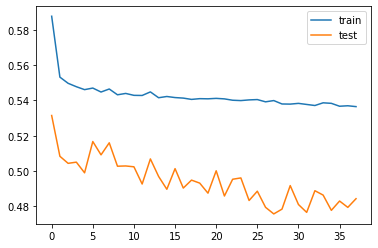

In [8]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import keras.utils

mlflow.set_experiment("LSTM")
mlflow.start_run()
mlflow.tensorflow.autolog()

# Define a seed for reproducibility
keras.utils.set_random_seed(42)

# LSTM model to predict air quality data for a 14 day lookback window and 1 day forecast using the train and test data.
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, activation='tanh', return_sequences=True)) # We avoid using activation='relu' because it disregards the negative values and this may result in information loss.
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=False)) # return_sequences=False for single output prediction (i.e. 1 day forecast)
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[2]))
model.compile(loss='mae', optimizer='adam')

# Train the model with early stopping.
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_test, Y_test), verbose=2, shuffle=False, callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)])

# Plot the model's predictions
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig("LSTM_loss.png")

# log and fetch the artifact
mlflow.log_artifact("LSTM_loss.png")

# mlflow.end_run()

plt.show()
plt.close()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 31,404
Trainable params: 31,404
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Evaluate the model on the test data after inverse scaling it.
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred)

# Reduce a dimension of the test data to inverse scale it.
Y_test_scaled = np.squeeze(Y_test, axis=1)

# Inverse scale the Y_test data.
Y_test_scaled = scaler.inverse_transform(Y_test_scaled)

# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(Y_pred - Y_test_scaled))
print("MAE = ", mae)
mlflow.log_metric("val_mae", mae)

42/42 [==============================] - 2s 10ms/step
MAE =  7.949462185579525


In [11]:
# Calculate the mean absolute error (MAE) for each contaminant.
mae_all = np.mean(np.abs(Y_pred - Y_test_scaled), axis=0)
# Round the values to 2 decimal places.
mae_all = np.around(mae_all, decimals=2)
# NO_2, SO_2, O_3, PM10, PM25
print("MAE (NO_2) = ", mae_all[0], "\nMAE (SO_2) = ", mae_all[1], "\nMAE (O_3) = ", mae_all[2], "\nMAE (PM10) = ", mae_all[3])
mlflow.log_metric("val_mae_NO_2", mae_all[0])
mlflow.log_metric("val_mae_SO_2", mae_all[1])
mlflow.log_metric("val_mae_O_3", mae_all[2])
mlflow.log_metric("val_mae_PM10", mae_all[3])

MAE (NO_2) =  12.99 
MAE (SO_2) =  1.88 
MAE (O_3) =  9.89 
MAE (PM10) =  7.04


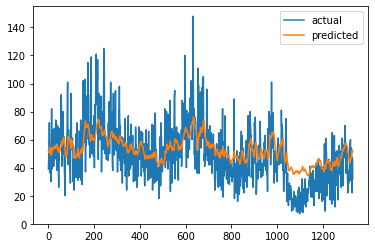

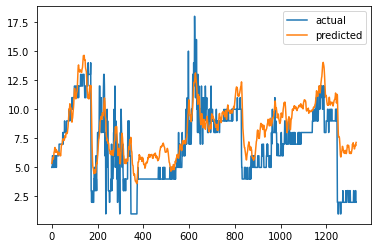

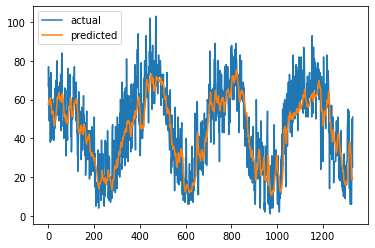

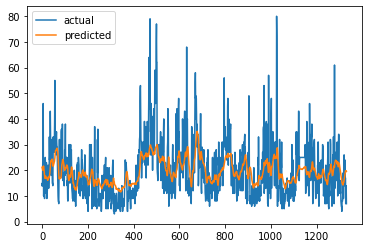

In [12]:
# Plot the predicted and actual air quality data for the test data for each contaminant.
for i in range(Y_test_scaled.shape[1]):
    plt.plot(Y_test_scaled[:, i], label='actual')
    plt.plot(Y_pred[:, i], label='predicted')
    plt.legend()
    plt.show()
    plt.close()

In [13]:
mlflow.end_run()